#  GraphConv Neural Network for Jet tagging using jet constituents from HLS data using DENSE ( or CONV ) layers on fully conected graphs

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

In [2]:
import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    


TensorFlow 2.5.0
No GPU available, using CPU !!!


# Load train and test JetID datasets as numpy arrays 

In [1]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]


Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems)



## Define a GraphConv NN by applying a convolutional layer (Conv1D) over each node of a fully connected Graph. Weights of  convolutional filter ( kernel ) are shared across the nodes by using a convolution sliding window of the size of the node features vector (kernel size) and a stride equal to the kernel size. 

### OBS: this Conv1D approach is equivalent to applying a a given MLP to each node individually and then aggregating the outputs

In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils
from qkeras import *

###########################################################################
# Define GraphConv Model 

#'''
# For 32 constituents
nchannels=36
poolsiz=6
nhidden1 = 22            
nhidden2 = 0
nhidden3 = 0
#'''

'''
# For 16 constituents
nchannels=40              
poolsiz=6
nhidden1 = 50
nhidden2 = 0 
nhidden3 = 0 
'''


'''
# For 8 constituents
nchannels=40                
poolsiz=3
nhidden1 = 50
nhidden2 = 0 
nhidden3 = 0 
'''

#############################################################################



# Number of target classes
ntargets = len(Y_train_val[0]) 

# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
#inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format


# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm')(inp)

############ Here we can use either CONDV or DENSE layers #############

# Conv1D with kernel_size=1 and stride=1 to get neighbouring nodes embedded features ( nchannels )
#hn = Conv1D(nchannels, kernel_size=1, strides=1, name='conv1D_2', use_bias="False" )(h)

# Dense layer to get each neighbouring node  embedded features ( nchannels ). 
# Weights acts only on features (tensor last component) and have the same value for all constituents ( shared weights )
hn = Dense(nchannels,name='dense_1',use_bias="False")(h)

# Conv1D with kernel_size=1 and stride=1 to get each node embedded features ( nchannels )
#   input node features ( pt, eta_rel, phi_rel) ---- mapped into ----> nchannels features 
#h = Conv1D(nchannels, kernel_size=1, strides=1, name='conv1D_1',
#             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)

# Dense layer to get each node embedded features ( nchannels ). 
# Weights acts only on features which are the last components and have the same value for all constituents 
h = Dense(nchannels,name='dense_2',use_bias="True")(h)

###################################################################################

# Agregate neighbouring nodes embedded features ( avg over all nodes for fully connected graph )
hn = GlobalAveragePooling1D(name='avgpool_1')(hn)      # sum features over constituents and normalize by nconstit 

# Add embedded each node features (h) to the aggregated neighbours features (hn)
hn = Reshape( (1,nchannels),name='reshap_2')(hn)       # reshape tensor to original 3D format (batch, 1, nfeat)
hn = UpSampling1D(size=nconstit,name='upsampl')(hn)    # make #(nconstit) copies of tensor along axis=1
h = Add(name='add1')([h,hn])       # add neighbours average features to each node feature ( W1.x+W2.x_avg_neighb+B1)

# Activate the agregated convolution
h = Activation( activation = "relu", name = 'activation_aggregation')(h)

# Reduce number of graph nodes by avg. pooling 
h = AveragePooling1D(pool_size=poolsiz, name='avgpool_2')(h)

# Flatten for MLP input ( now each constituent embedded feature gets an independent weight )
h = Flatten(name='Flatten')(h)

# Dense layers for classification
h = Dense(nhidden1, name='dense_3', activation="relu")(h)


out = Dense(ntargets, name='denseOut',  activation="softmax")(h)  # (N, num_classes)

'''
# Build a dummy model to test output values of layers
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
h = BatchNormalization(name='BatchNorm')(inp)
h  = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D',
             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)
h = tf.keras.backend.sum(h,axis=1)
out = h
model = Model(inputs=inp, outputs=out)
Y = model.predict(X_train_val)
print("shape X",Y.shape)
print("X[0,:]=",Y[0,:])
'''

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0001)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
BatchNorm (BatchNormalization)  (None, 32, 3)        12          inp[0][0]                        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32, 36)       144         BatchNorm[0][0]                  
__________________________________________________________________________________________________
avgpool_1 (GlobalAveragePooling (None, 36)           0           dense_1[0][0]                    
______________________________________________________________________________________________

## Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# Set model and output name
arch = 'GraphConv'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)


# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch')

# Train classifier
history = model.fit( X_train_val , Y_train_val, 
                    epochs=50, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chkp], 
                    validation_split=0.3 )   


Epoch 1/300
807/807 [==============================] - 4s 4ms/step - loss: 1.4765 - categorical_accuracy: 0.3508 - val_loss: 1.3352 - val_categorical_accuracy: 0.4515
Epoch 2/300
807/807 [==============================] - 3s 4ms/step - loss: 1.2803 - categorical_accuracy: 0.4819 - val_loss: 1.2374 - val_categorical_accuracy: 0.5093
Epoch 3/300
807/807 [==============================] - 4s 4ms/step - loss: 1.2001 - categorical_accuracy: 0.5269 - val_loss: 1.1702 - val_categorical_accuracy: 0.5354
Epoch 4/300
807/807 [==============================] - 4s 4ms/step - loss: 1.1492 - categorical_accuracy: 0.5453 - val_loss: 1.1349 - val_categorical_accuracy: 0.5497
Epoch 5/300
807/807 [==============================] - 3s 4ms/step - loss: 1.1240 - categorical_accuracy: 0.5534 - val_loss: 1.1175 - val_categorical_accuracy: 0.5539
Epoch 6/300
807/807 [==============================] - 4s 4ms/step - loss: 1.1103 - categorical_accuracy: 0.5592 - val_loss: 1.1060 - val_categorical_accuracy: 0.559

/Users/sznajder/WorkM1/miniforge3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


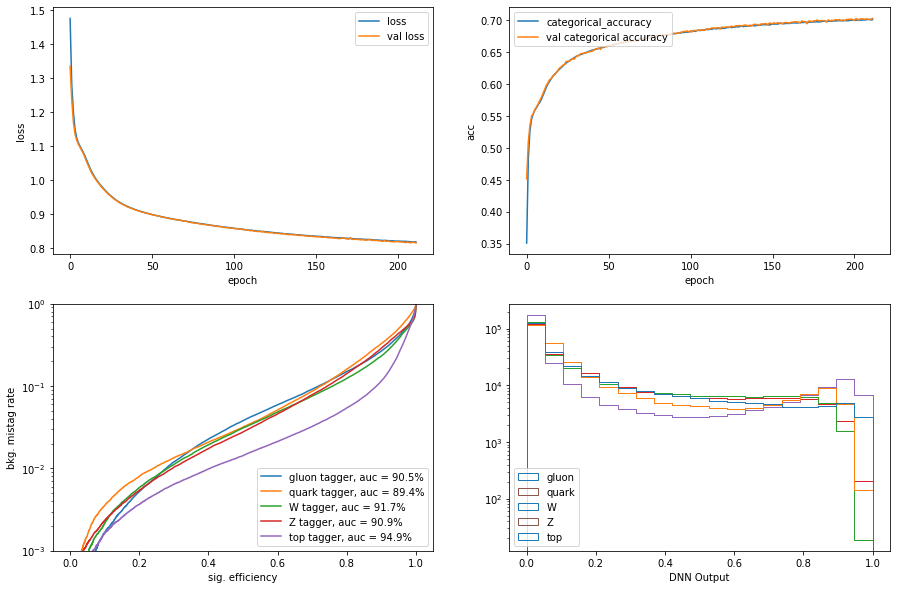

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')


# Display plots
fig = plt.gcf()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)



# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)


'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''

'''
# Save a sample of events for HLS
njets=3000
print(X_test.shape)
np.save('x_test.npy', X_test[0:njets,:])
np.save('y_test.npy', Y_test[0:njets,:])
'''

Label =  gluon  with treshold =  0.3
TPR =  0.3000017104835537
FPR =  0.012003259505814079
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000256572533055
FPR =  0.03806205995593631
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000444725723962
FPR =  0.15015715474460736
 
Label =  quark  with treshold =  0.3
TPR =  0.3001026476001699
FPR =  0.01344614700550672
 
Label =  quark  with treshold =  0.5
TPR =  0.5000176978620983
FPR =  0.031804733727810654
 
Label =  quark  with treshold =  0.8
TPR =  0.8000318561517769
FPR =  0.16065687314019905
 
Label =  W  with treshold =  0.3
TPR =  0.30018687743240696
FPR =  0.011207680341961365
 
Label =  W  with treshold =  0.5
TPR =  0.5000428617964237
FPR =  0.030929922912187113
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.12406871975628359
 
Label =  Z  with treshold =  0.3
TPR =  0.3000154276016936
FPR =  0.010346328367727729
 
Label =  Z  with treshold =  0.5
TPR =  0.5000085708898298
FPR =  0.027755394009385384
 
L

"\n# Save a sample of events for HLS\nnjets=3000\nprint(X_test.shape)\nnp.save('x_test.npy', X_test[0:njets,:])\nnp.save('y_test.npy', Y_test[0:njets,:])\n"